In [136]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import ConfusionMatrixDisplay

In [137]:
# Importing the pre-processed version of the data and turning the target variable into a binary variable
df = pd.read_csv("preproc_data.csv")
df = df.iloc[:, 1:]
df['churn'] = df['churn'].map({'No': 0, 'Yes': 1})
df.describe(include='all')

,churn,accountlength,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalintlcalls,totalintlcharge,numbercustomerservicecalls
count,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000
mean,0.136287,0.457745,0.905696,0.739873,0.159757,0.505552,0.500827,0.498255,0.494973,0.500983,0.494609,0.331994,0.503846,0.304536
std,0.343129,0.181672,0.292282,0.438750,0.279362,0.166457,0.168083,0.167155,0.166495,0.165245,0.166795,0.214228,0.160508,0.241370
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.333333,1.000000,0.000000,0.000000,0.390718,0.387931,0.384615,0.381154,0.390203,0.384615,0.200000,0.397727,0.200000
50%,0.000000,0.458333,1.000000,1.000000,0.000000,0.503606,0.500000,0.504274,0.495865,0.501166,0.495726,0.300000,0.509091,0.200000
75%,0.000000,0.578704,1.000000,1.000000,0.333333,0.618140,0.612069,0.615385,0.605849,0.614878,0.606838,0.500000,0.613636,0.400000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [138]:
# Separating the dependent from the independent variables
X = df.drop('churn', axis=1).to_numpy()
y = df.loc[:, 'churn'].to_numpy()

Since our data has unbalanced classes, we will apply one of the techniques we saw on the pre-processing phase. For the SVM, since it depends heavily on the support vectors, it may be a good idea to do undersampling: reducing the data may lead to fairly equal results as oversampling, and in this case we reduce the training time for the model.


In [139]:
# Apply undersampling to the imbalanced class

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

count_no = np.sum(ytrain == 0)
count_yes = np.sum(ytrain == 1)
print(f"Array before: yes {count_yes}, no {count_no}")

# Apply RandomUnderSampler to address class imbalance
rus = RandomUnderSampler(random_state=42)
Xtrain, ytrain = rus.fit_resample(Xtrain, ytrain)

count_no = np.sum(ytrain == 0)
count_yes = np.sum(ytrain == 1)
print(f"Array after: yes {count_yes}, no {count_no}")


Array before: yes 519, no 3273
Array after: yes 519, no 519


Before doing hyperparameter tuning, we get an overall understanding of how each kernel behaves with this data by evaluating it with a simple holdout method.

In [140]:
def evaluate(model, model_name):
    predictions = model.predict(Xtest)

    cm = metrics.confusion_matrix(ytest, predictions)

    ConfusionMatrixDisplay.from_estimator(model, Xtest, ytest)
    plt.show()

    tp = cm[1][1]
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    total = tp + tn + fp + fn
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)

    print(f"{model_name} Kernel SVM:")
    print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

    print(f"Accuracy: {(tp+tn)/total}")
    print(f"Error: {1-(tp+tn)/total}")
    print(f"Recall: {recall}")
    print(f"Specificity: {tn/(tn+fp)}")
    print(f"Precision: {precision}")
    print(f"F1: {2*recall*precision/(recall+precision)}")


In [141]:
svmLinear = SVC(kernel='linear', C=100)
svmLinear.fit(Xtrain, ytrain)

SVC(C=100, kernel='linear')

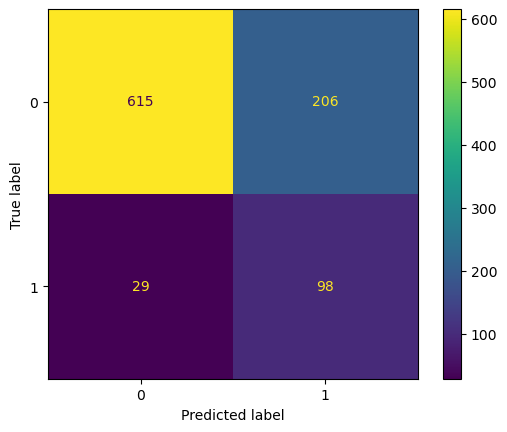

Linear Kernel SVM:
TP: 98, TN: 615, FP: 206, FN: 29
Accuracy: 0.7521097046413502
Error: 0.24789029535864981
Recall: 0.7716535433070866
Specificity: 0.7490864799025578
Precision: 0.3223684210526316
F1: 0.4547563805104408


In [142]:
evaluate(svmLinear, "Linear")

In [143]:
svmPoly = SVC(kernel='poly', C=100)
svmPoly.fit(Xtrain, ytrain)

SVC(C=100, kernel='poly')

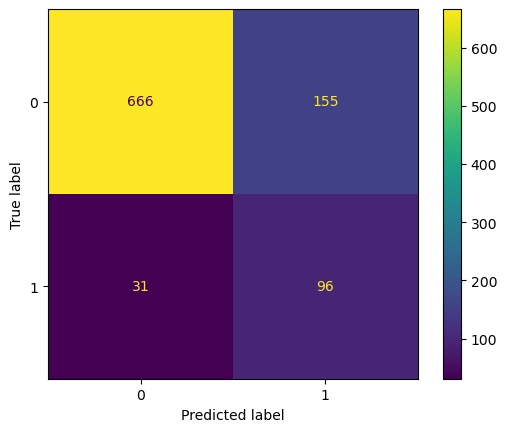

Polinomial Kernel SVM:
TP: 96, TN: 666, FP: 155, FN: 31
Accuracy: 0.8037974683544303
Error: 0.19620253164556967
Recall: 0.7559055118110236
Specificity: 0.8112058465286236
Precision: 0.38247011952191234
F1: 0.5079365079365078


In [144]:
evaluate(svmPoly, "Polinomial")

In [145]:
svmRBF = SVC(kernel='rbf', C=100)
svmRBF.fit(Xtrain, ytrain)

SVC(C=100)

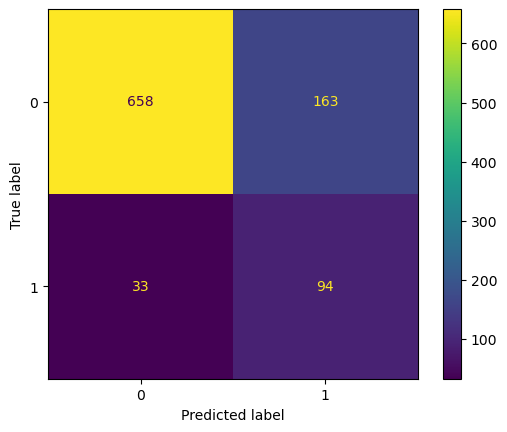

RBF Kernel SVM:
TP: 94, TN: 658, FP: 163, FN: 33
Accuracy: 0.7932489451476793
Error: 0.2067510548523207
Recall: 0.7401574803149606
Specificity: 0.8014616321559074
Precision: 0.3657587548638132
F1: 0.4895833333333333


In [146]:
evaluate(svmRBF, "RBF")

In [147]:
svmSigmoid = SVC(kernel="sigmoid", C=100)
svmSigmoid.fit(Xtrain, ytrain)

SVC(C=100, kernel='sigmoid')

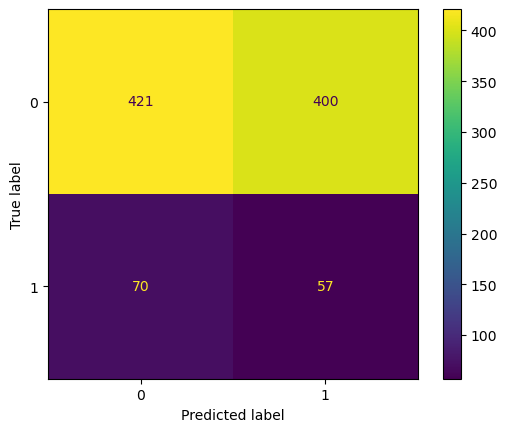

Sigmoid Kernel SVM:
TP: 57, TN: 421, FP: 400, FN: 70
Accuracy: 0.5042194092827004
Error: 0.49578059071729963
Recall: 0.44881889763779526
Specificity: 0.51278928136419
Precision: 0.12472647702407003
F1: 0.1952054794520548


In [148]:
evaluate(svmSigmoid, "Sigmoid")

Still using simple holdout technique, we will see how changing the hyperparameter C affects the recall of the model.

In [149]:
def recall_testing(kernel, n, div):
    recalls = [0] * (n-1)
    list = [*range(1, n)]
    cValues = [x/div for x in list]

    j = 0
    for i in cValues:
        svmPoly = SVC(kernel=kernel, C=i)
        svmPoly.fit(Xtrain, ytrain)

        predictions = svmPoly.predict(Xtest)
        recall = metrics.recall_score(ytest, predictions)

        recalls[j] = recall
        j+=1

    plt.scatter(cValues, recalls)

    plt.xlabel('C')
    plt.ylabel('Recall')

    plt.title(f'Relation between hyperparameter C and Recall for {kernel}')
    plt.show()


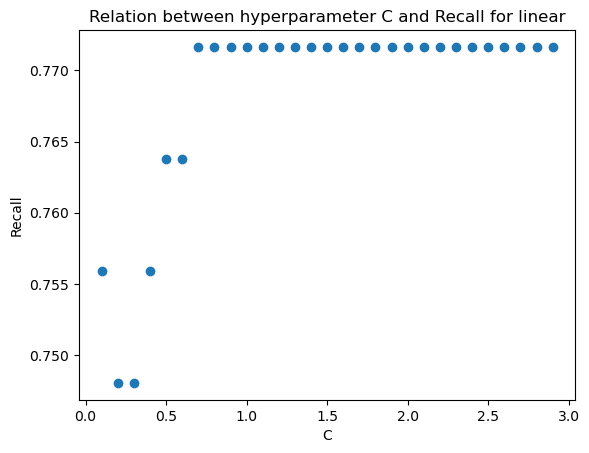

In [150]:
recall_testing('linear', 30, 10)

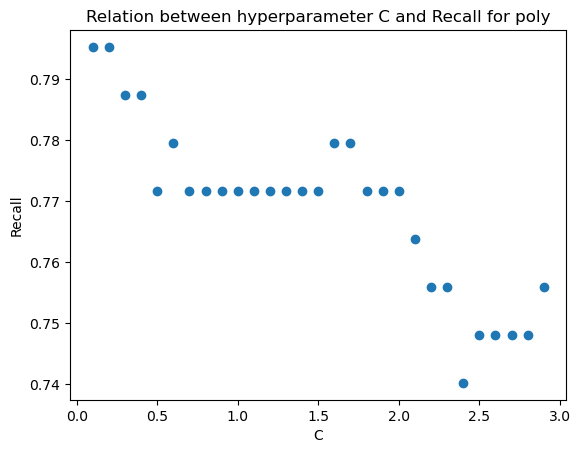

In [151]:
recall_testing('poly', 30, 10)

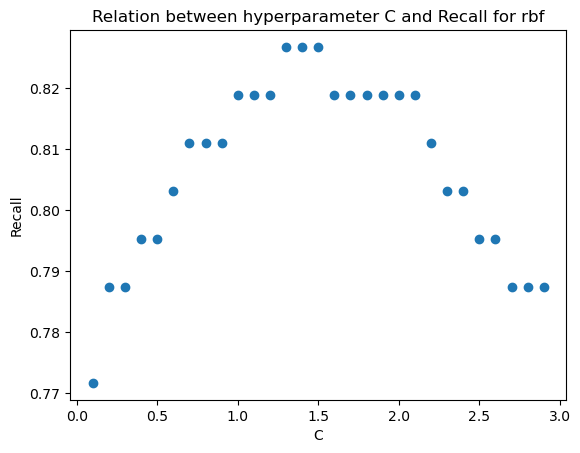

In [152]:
recall_testing('rbf', 30, 10)

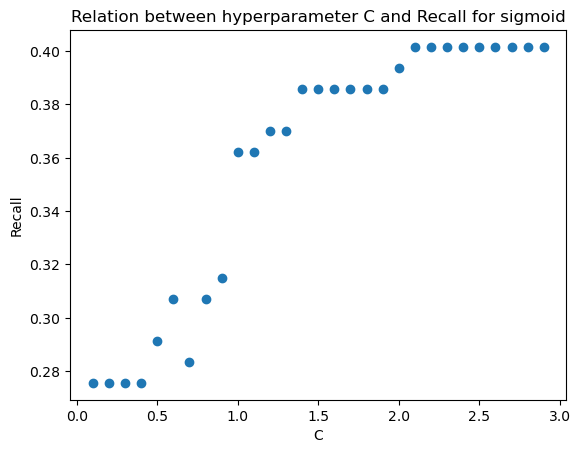

In [153]:
recall_testing('sigmoid', 30, 10)

Overall, the sigmoid function does not seem to have a good scoring, so we will stop evaluating it.
Except for the case of the polynomial, we can see that setting a very small value for C leads to bad results, possibly because of overfitting.
The best results were for the rbf kernel, with a hyperparameter C of around 1.5.
Next, we will do hyperparameter tuning using a validation set with 10-fold cross-validation.

In [154]:
def cvSVMC(kernel, n, div, scoring):
    recalls = [0] * (n-1)
    std = [0] * (n-1)
    list = [*range(1, n)]
    cValues = [x/div for x in list]
    j = 0
    for i in cValues:
        svm = SVC(kernel=kernel, C=i)
        scores=cross_val_score(svm, Xtrain, ytrain, cv=10, scoring=scoring)

        std[j] = scores.std()
        recalls[j] = scores.mean()
        j+=1

    print(f"Standard Deviations: {std}")
    plt.scatter(cValues, recalls)

    plt.xlabel('C')
    plt.ylabel(scoring)

    plt.title(f'Relation between hyperparameter C and {scoring} for {kernel}')
    plt.show()
    

Standard Deviations: [0.06355721353913986, 0.06606073338281872, 0.0658776173339051, 0.06544160829537449, 0.0660161650447406, 0.06670154967346116, 0.06813721316714927, 0.06778799943651091, 0.06778799943651091, 0.06670154967346116, 0.06778799943651091, 0.06826395871630973, 0.06778799943651091, 0.06423091798817895, 0.06409506654760647, 0.062146092650787, 0.06346372289844557, 0.06346372289844557, 0.06321586406903311, 0.06290826945763267, 0.06321586406903311, 0.06290826945763267, 0.06921915413364246, 0.06518847762645591, 0.064043802363477, 0.06850784332836252, 0.06850784332836252, 0.06850784332836252, 0.06850784332836252]


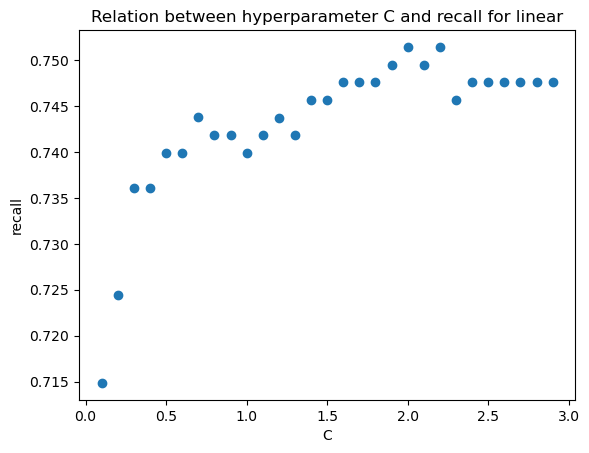

In [155]:
cvSVMC('linear', n=30, div=10, scoring='recall')

Aside from small variances, after C=1.5 the values for the recall with linear kernel stay relatively the same.

Standard Deviations: [0.03678604787206191, 0.03380713091889172, 0.03515625266596361, 0.04808792350416748, 0.05186488127614778, 0.05358947243121036, 0.0481678671375618, 0.04838191785394345, 0.04988726259586281, 0.0481678671375618, 0.04750390483088235, 0.05033224821296762, 0.04900736591539812, 0.04678405359750378, 0.04406380866244338, 0.04113501302492743, 0.03725757344126136, 0.03835753616691495, 0.03835753616691495, 0.03930985980434946, 0.038308352114536745, 0.041036383452939224, 0.03835753616691495, 0.037257573441261356, 0.037257573441261356, 0.03466710122422995, 0.0349078600095237, 0.0349078600095237, 0.0349078600095237, 0.0349078600095237, 0.0349078600095237, 0.0349078600095237, 0.03466710122422995, 0.03466710122422995, 0.03466710122422995, 0.0349078600095237, 0.0349078600095237, 0.0349078600095237, 0.03906057981910605]


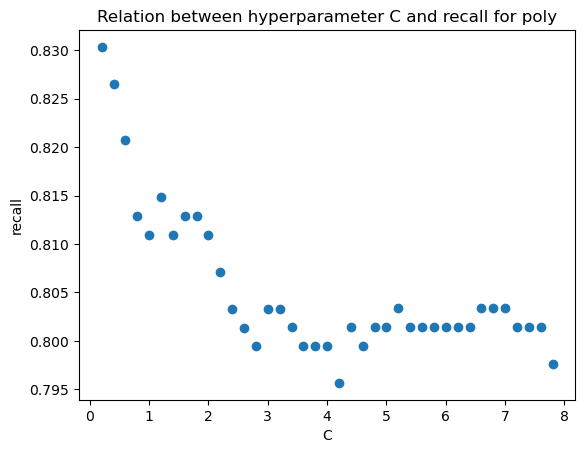

In [156]:
cvSVMC('poly', n=40, div=5, scoring='recall')

For the polynomial kernel, we have high values of recall for small values of C, which, again, may indicate overfitting. After C=2, the values for the recall decrease, a possible sign of underfitting. An adequate value would be around 1.5.

Standard Deviations: [0.061713579467401504, 0.0542014590336903, 0.044660197955946675, 0.04793978310976053, 0.045377973811356116, 0.045377973811356116, 0.04877966569277188, 0.048528532796590945, 0.04502584555353954, 0.04502584555353954, 0.04286335283315878, 0.04286335283315878, 0.04071245856742252, 0.04289717455277549, 0.04289717455277549, 0.04335202156449404, 0.04503849095502785, 0.04718121339418025, 0.04718121339418025, 0.039084651716437914, 0.04308588755158205, 0.04040473154518044, 0.04028880735128235, 0.04028880735128235, 0.04028880735128235, 0.03947882766998888, 0.03947882766998888, 0.043366384584969705, 0.0458336551867306, 0.0458336551867306, 0.0458336551867306, 0.0458534273865734, 0.0458534273865734, 0.04228611091667025, 0.04228611091667025, 0.04228611091667025, 0.04228611091667025, 0.04115548791622735, 0.04081667847982991, 0.03945715843650328, 0.03945715843650328, 0.03945715843650328, 0.03945715843650328, 0.03945715843650328, 0.04081667847982991, 0.04081667847982991, 0.040816678

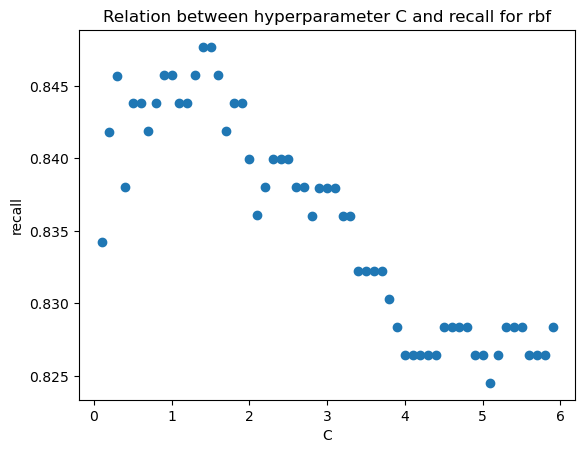

In [157]:
cvSVMC('rbf', n = 60, div=10, scoring='recall')

The RBF Kernel seems to have good values of recall for C around 1.5, and decreases after C = 2, indicating underfitting. Therefore, adequate values would be greater than 1 and smaller than 2. We can also see that the overall recall is the highest for this kernel. Choosing the rbf kernel with C=1.5 seems like a viable choice. Before continuing, we will also see how the accuracy varies in regard to the hyperparameter C.

Standard Deviations: [0.02726608528885089, 0.02857242220028353, 0.027536266788887147, 0.026270309132445106, 0.029381107573906, 0.030092733570884822, 0.028898094872827077, 0.028898094872827074, 0.029766578876450213, 0.029766578876450213, 0.029205678362936336, 0.029205678362936336, 0.02871971541726635, 0.029226724040941367, 0.029693966226421797, 0.027062269534297963, 0.03300386440217193, 0.033142343924919535, 0.033142343924919535, 0.02970825566411676, 0.0318902349349303, 0.031005823884674738, 0.03037066277123704, 0.029624379343377815, 0.029624379343377815, 0.029477202945084376, 0.029477202945084376, 0.031971578307930536, 0.03158773226895061, 0.02726065277904712, 0.02691936228218296, 0.028510754628674844, 0.026646719648453904, 0.024821075231947196, 0.026044888850889857, 0.027088920392593568, 0.027194914958763385, 0.02507222874122366, 0.025149976803255848, 0.025555195639843806, 0.026093502182222485, 0.029036071997930155, 0.029036071997930155, 0.029036071997930155, 0.029911203975196476, 0.0

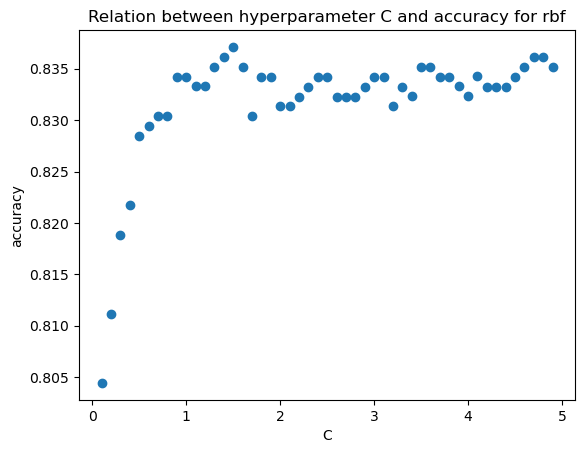

In [158]:
cvSVMC('rbf', n=50, div=10, scoring='accuracy')

We can see that the accuracy and the recall vary very differently, but we do have high values of accuracy for C=1.5 compared with other smaller values. We will then use the RBF kernel with C=1.5. Now, we will again apply 10-fold cross-validation to choose a value for the gamma hyperparameter.

In [159]:
def cvSVMGamma(kernel, n, div, scoring):
    recalls = [0] * (n-1)
    std = [0] * (n-1)
    list = [*range(1, n)]
    cValues = [x/div for x in list]
    j = 0
    for i in cValues:
        svm = SVC(kernel=kernel, C=1.5, gamma=i)
        scores=cross_val_score(svm, Xtrain, ytrain, cv=10, scoring=scoring)

        std[j] = scores.std()
        recalls[j] = scores.mean()
        j+=1

    print(f"Standard Deviations: {std}")
    plt.scatter(cValues, recalls)

    plt.xlabel('C')
    plt.ylabel('Recall')

    plt.title(f'Relation between hyperparameter gamma and Recall for {kernel}')
    plt.show()

Standard Deviations: [0.060094283974103796, 0.04643923499628732, 0.04293578822718629, 0.04228167225604047, 0.041397769405196266, 0.04644956720976337, 0.04289717455277549, 0.04071245856742252, 0.04289717455277549, 0.04355952806220879, 0.0410492186984481, 0.045566756670698205, 0.045566756670698205, 0.0412677373509356, 0.04133357850494841, 0.03831837208544323, 0.03805346467683676, 0.03805346467683676, 0.038657505815576476, 0.038657505815576476, 0.039013211492425016, 0.039013211492425016, 0.04111193416032302, 0.04111193416032302, 0.04036163585664467, 0.03831837208544323, 0.03848548628952927, 0.03927164544961028, 0.03994990823511493, 0.03994990823511493, 0.03994990823511493, 0.03994990823511493, 0.04020232124344707, 0.04100331550289677, 0.04100331550289677, 0.04100331550289677, 0.04362528364783838, 0.04362528364783838, 0.04362528364783838]


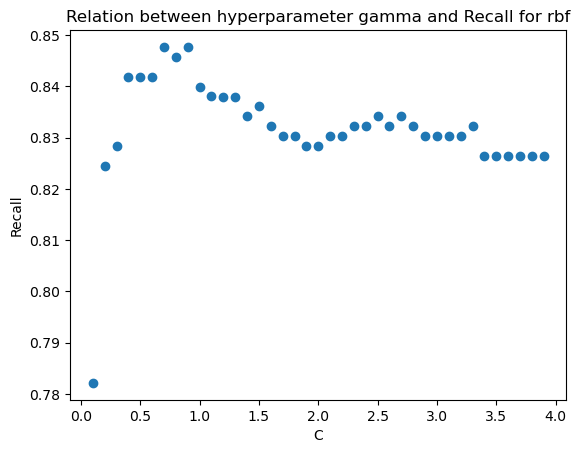

In [160]:
cvSVMGamma('rbf', 40, 10, 'recall')

We can see that after gamma=1, the recall slowly decreases. We will choose gamma=1 as our hyperparameter.

In [161]:
# Best Results: kernel='rbf', C=1.5, gamma=1

svmRBF = SVC(kernel='rbf', C=1.5, gamma=1)
svmRBF.fit(Xtrain, ytrain)

SVC(C=1.5, gamma=1)

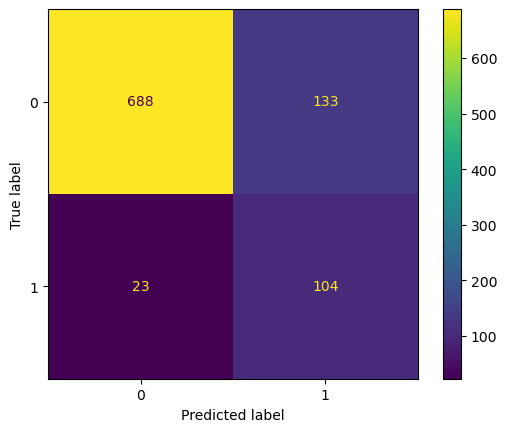

RBF Kernel SVM:
TP: 104, TN: 688, FP: 133, FN: 23
Accuracy: 0.8354430379746836
Error: 0.16455696202531644
Recall: 0.8188976377952756
Specificity: 0.8380024360535931
Precision: 0.4388185654008439
F1: 0.5714285714285715


In [162]:
evaluate(svmRBF, 'RBF')

Finally testing the model with all the hyperparameters chosen, we get an accuracy of 83% and a recall of 81%.
These are not bad values, but perhaps other models can do better. It may also be the case that the rbf kernel is not able to make a linear separation of this dataset, and other kernels may even be better. It does seem, however, that for the tested kernels (and hyperparameters), this is the best option.